### Horikawa & Kamitani (2017) experiment on AlexNets

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd 
import glob
import pickle
import tables

from pylab import *
from hurry.filesize import size

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(style = 'white', font_scale=1.3)

import train_util as tu
from models import alexnet
from qmvpa import rsa
from qutils import * 

%autosave 5

condition = 'test'

# top_k = 5
# k_patches = 5
# display_step = 10
n_layers = 8
layer_names = ['conv%d' % (l+1) for l in range(5)] + ['fc%d' % (l+1) for l in range(3)]

ckpt_path = '/tigress/qlu/logs/ILSVRC2012/ckpt-alexnet00'
imagenet_path = '/scratch/gpfs/qlu/ILSVRC2012'
print(ckpt_path)


# kamitani specific dir 
kamitani_path = '/scratch/gpfs/qlu/kamitani2017/images'
category_im_dir = train_im_dir = 'training'
instance_im_dir = test_im_dir = 'test'
train_ims_root = os.path.join(kamitani_path, category_im_dir)
test_ims_root = os.path.join(kamitani_path, instance_im_dir)

# stim order files 
label_map_dir = '/tigress/qlu/data/fmri_imagenet/data/labelmaps'
train_stim_order_fname = 'train_stimuli_presentation_order.npz'
test_stim_order_fname = 'test_stimuli_presentation_order.npz'

# load the bijection: full_id <-> image_full_name
map_path = os.path.join(label_map_dir, 'dict_im_full_name_to_full_id.pickle')
with open(map_path, 'rb') as handle:
    dict_im_full_name_to_full_id = pickle.load(handle)

/home/qlu/.conda/envs/brainiak/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Autosaving every 5 seconds
/tigress/qlu/logs/ILSVRC2012/ckpt-alexnet00


In [2]:
# get image paths in the correct order 
def get_ordered_im_paths(condition):
    if condition == 'train': 
        stim_order_fname = train_stim_order_fname
        ims_root = train_ims_root
    elif condition == 'test':
        stim_order_fname = test_stim_order_fname
        ims_root = test_ims_root
    else:
        raise ValueError('unrecog condition')
        
    _, stim_ordered_im_paths = read_stimuli_order(
        stim_order_fname, label_map_dir)
    stim_ordered_im_paths_tiger = []

    for im_raw_path in stim_ordered_im_paths: 
        im_dir = os.path.basename(os.path.dirname(im_raw_path))
        im_name = os.path.basename(im_raw_path)
        im_path = os.path.join(ims_root, im_dir, im_name)
        assert os.path.exists(im_path)
        stim_ordered_im_paths_tiger.append(im_path)
    return stim_ordered_im_paths_tiger

# read the paths for training set and test set 
# in order! 
train_stim_ordered_im_paths_tiger = get_ordered_im_paths('train')
test_stim_ordered_im_paths_tiger = get_ordered_im_paths('test')

In [3]:
# set up the computational graph 
x = tf.placeholder(tf.float32, [None, 224, 224, 3])
y = tf.placeholder(tf.float32, [None, 1000])

_, pred = alexnet.classifier(x, 1.0)

# # calculate the average precision of the crops of the image
# avg_prediction = tf.div(tf.reduce_sum(pred, 0), k_patches)

# # preallocate for accuracy
# top1_correct = tf.equal(tf.argmax(avg_prediction, 0), tf.argmax(y, 1))
# top1_accuracy = tf.reduce_mean(tf.cast(top1_correct, tf.float32))
# topk_correct = tf.nn.in_top_k(tf.stack([avg_prediction]), tf.argmax(y, 1), k=top_k)
# topk_accuracy = tf.reduce_mean(tf.cast(topk_correct, tf.float32))

# load the model back 
saver = tf.train.Saver()

In [4]:
sess = tf.InteractiveSession()
saver.restore(sess, os.path.join(ckpt_path, 'alexnet-cnn.ckpt'))

INFO:tensorflow:Restoring parameters from /tigress/qlu/logs/ILSVRC2012/ckpt-alexnet00/alexnet-cnn.ckpt


In [5]:
# choose the number of repeats 
# k_patches = 50

# define the image set
if condition == 'train':
    image_set = train_stim_ordered_im_paths_tiger
    k_patches = 1
elif condition == 'test':
    image_set = test_stim_ordered_im_paths_tiger
    k_patches = 45
else:
    raise ValueError('unrecog condition')

# get layer name 
conv1 = tf.get_default_graph().get_tensor_by_name('alexnet_cnn/alexnet_cnn_conv1/Relu:0')
conv2 = tf.get_default_graph().get_tensor_by_name('alexnet_cnn/alexnet_cnn_conv2/Relu:0')
conv3 = tf.get_default_graph().get_tensor_by_name('alexnet_cnn/alexnet_cnn_conv3/Relu:0')
conv4 = tf.get_default_graph().get_tensor_by_name('alexnet_cnn/alexnet_cnn_conv4/Relu:0')
conv5 = tf.get_default_graph().get_tensor_by_name('alexnet_cnn/alexnet_cnn_conv5/Relu:0')
fc1 = tf.get_default_graph().get_tensor_by_name('alexnet_classifier/alexnet_classifier_fc1/Relu:0')
fc2 = tf.get_default_graph().get_tensor_by_name('alexnet_classifier/alexnet_classifier_fc2/Relu:0')
fc3 = tf.get_default_graph().get_tensor_by_name('alexnet_classifier/alexnet_classifier_output/Add:0')

n_imgs = len(image_set)
# fetches = []
conv1s, conv2s, conv3s, conv4s, conv5s, fc1s, fc2s, fc3s = [], [], [], [], [], [], [], []

conv1_fs = np.zeros([n_imgs, k_patches] + conv1.get_shape().as_list()[1:])
conv2_fs = np.zeros([n_imgs, k_patches] + conv2.get_shape().as_list()[1:])
conv3_fs = np.zeros([n_imgs, k_patches] + conv3.get_shape().as_list()[1:])
conv4_fs = np.zeros([n_imgs, k_patches] + conv4.get_shape().as_list()[1:])
conv5_fs = np.zeros([n_imgs, k_patches] + conv5.get_shape().as_list()[1:])
fc1_fs = np.zeros([n_imgs, k_patches] + fc1.get_shape().as_list()[1:])
fc2_fs = np.zeros([n_imgs, k_patches] + fc2.get_shape().as_list()[1:])
fc3_fs = np.zeros([n_imgs, k_patches] + fc3.get_shape().as_list()[1:])

for im_idx in range(n_imgs):

    image_patches = tu.read_k_patches(image_set[im_idx], k_patches)

    # gather neural activity 
    fetch_list = [conv1, conv2, conv3, conv4, conv5, fc1, fc2, fc3]
    fetched_list = sess.run(fetch_list, feed_dict={x: image_patches})
    [conv1_f, conv2_f, conv3_f, conv4_f, conv5_f, fc1_f, fc2_f, fc3_f] = fetched_list

    # collect the activities
    conv1_fs[im_idx] = conv1_f
    conv2_fs[im_idx] = conv2_f
    conv3_fs[im_idx] = conv3_f
    conv4_fs[im_idx] = conv4_f
    conv5_fs[im_idx] = conv5_f
    fc1_fs[im_idx] = fc1_f
    fc2_fs[im_idx] = fc2_f
    fc3_fs[im_idx] = fc3_f
    
# flatten arrays for conv layers 
conv1_fs = np.reshape(conv1_fs, [n_imgs, k_patches, -1])
conv2_fs = np.reshape(conv2_fs, [n_imgs, k_patches, -1])
conv3_fs = np.reshape(conv3_fs, [n_imgs, k_patches, -1])
conv4_fs = np.reshape(conv4_fs, [n_imgs, k_patches, -1])
conv5_fs = np.reshape(conv5_fs, [n_imgs, k_patches, -1])

In [6]:
act_path = os.path.join(ckpt_path, 'acts', condition)
if not os.path.exists(act_path):
    os.makedirs(act_path)
print(act_path) 

layer_names = ['conv%d' % (l+1) for l in range(5)] + ['fc%d' % (l+1) for l in range(3)]
layer_acts_fs = [conv1_fs, conv2_fs, conv3_fs, conv4_fs, conv5_fs, 
              fc1_fs, fc2_fs, fc3_fs]

for layer_act, layer_name in zip(layer_acts_fs, layer_names): 
    print('Save %s: size = %s' % (layer_name, np.shape(layer_act)))
    np.savez_compressed(os.path.join(act_path, layer_name), 
                        acts=layer_act)

/tigress/qlu/logs/ILSVRC2012/ckpt-alexnet00/acts/test
Save conv1: size = (50, 45, 301056)
Save conv2: size = (50, 45, 186624)
Save conv3: size = (50, 45, 64896)
Save conv4: size = (50, 45, 64896)
Save conv5: size = (50, 45, 43264)
Save fc1: size = (50, 45, 4096)
Save fc2: size = (50, 45, 4096)
Save fc3: size = (50, 45, 1000)


In [7]:
# def unroll_acts_list(acts_list):
#     """Unroll the layer-wise activation for a patches of images 
    
#     Parameters: 
#     -----------------
#     acts_list: a list with length == number of layers in a neural network 
#         - each entry has shape (n_patches, h, w, n_filters)

#     Returns: 
#     -----------------    
#     acts_list_ur: a list of unrolled activity 
#         - each entry has shape (n_patches, h x w x n_filters)
#     """
#     n_layers = len(acts_list)
#     acts_list_ur = []
#     for l in range(n_layers): 
#         acts_list_ur.append(np.reshape(acts_list[l], (k_patches, -1)))
#     return acts_list_ur

# def unroll_acts_lists(acts_lists): 
#     """The wrapper for unroll_acts_list, over all images 
#     """
#     n_images = len(acts_lists)
#     acts_lists_ur = []
#     for im_idx in range(n_images): 
#         acts_lists_ur.append(unroll_acts_list(acts_lists[im_idx]))
#     return acts_lists_ur

# def print_shapes_arraylist(arraylist):
#     for arr in arraylist: 
#         print(np.shape(arr))

# def print_dims_arraylist(arraylist):
#     for arr in arraylist: 
#         print(np.cumprod(np.shape(arr))[-1])

In [8]:
# np.shape()
# temp = pd.DataFrame(data = to_mat(fc3_fs))
# temp

In [9]:
# unroll activities for all images 
# acts_lists_ur [n_imgs][n_layer][n_patches, n_units]
# acts_lists_ur = unroll_acts_lists(fetches)

# save activities 

In [10]:
# # average out k patches 
# for i in range(n_imgs):
#     for l in range(n_layers): 
#         acts_lists_ur[i][l] = np.mean(acts_lists_ur[i][l], axis = 0)

In [11]:
# h5file = openFile(os.path.join(ckpt_path, 'acts_test.h5'), 
#                          mode='w', title="acts_test")
# root = h5file.root
# h5file.createArray(root, "test", acts_lists_ur)
# h5file.close()

In [12]:
# l = 0 
# im_id = 0 

# size(acts_lists_ur[im_id][l].nbytes)

# def compute_size(acts_lists_ur): 
#     n_bytes = 0
#     for im_id in range(n_imgs):
#         for l in range(n_layers):
#             n_bytes += acts_lists_ur[im_id][l].nbytes
#     return size(n_bytes)
            
# print(compute_size(acts_lists_ur))

In [13]:
def to_mat(raw_acts):
    return np.reshape(raw_acts, [-1, np.shape(raw_acts)[-1]]).T


def show_heatmap(heatmap, k):
    # compute a mask
    mask = np.zeros(np.shape(heatmap))
    mask[np.triu_indices_from(mask, k=k)] = True
    # manage tick frequency 
    tick_frequency = 10
    n_egs = np.shape(heatmap)[0]
    n_ticks = n_egs//tick_frequency
    # plot 
    my_heatmap = sns.heatmap(heatmap,
                            cmap="viridis",
                            xticklabels = n_ticks, 
                            yticklabels = n_ticks,
                            mask=mask, square=True,
                            cbar=True)
    return my_heatmap

In [14]:
# RSA
from qmvpa.utils import window_avg

# layer_id = 7
act_mat = to_mat(fc3_fs)
# act_mat = window_avg(act_mat.T, 8).T
# print(np.shape(act_mat))

rsm = rsa.inter_RSM(act_mat, act_mat)

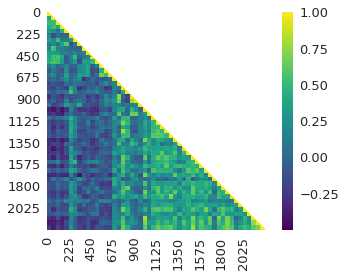

In [15]:
"""heat map"""
rsm_plt = show_heatmap(rsm, 1)

In [16]:
# """violin"""
# n_ani = 14
# n_inani = n_imgs - n_ani
# rsm_tril = np.tril(rsm, -1)

# corrs_ani = np.reshape(rsm_tril[:n_ani, :n_ani], (-1,))
# corrs_inani = np.reshape(rsm_tril[n_ani:, n_ani:], (-1,))
# corrs_cross = np.reshape(rsm_tril[n_ani:, :n_ani], (-1))

# corrs_ani = corrs_ani[corrs_ani != 0]
# corrs_inani = corrs_inani[corrs_inani !=0 ]
# corrs_cross = corrs_cross[corrs_cross != 0]

# mean_ani = np.mean(corrs_ani)
# mean_inani = np.mean(corrs_inani)
# mean_cross = np.mean(corrs_cross)

In [17]:
# corrs = pd.DataFrame({
#     'correlation' : np.concatenate([corrs_ani, corrs_inani, corrs_cross]), 
#     'conditions':['w/in animates'] * len(corrs_ani) +  ['w/in inanimates'] * len(corrs_inani) + 
#     ['across'] * len(corrs_cross)
# })
# ax = sns.violinplot(x = 'conditions', y = 'correlation', data=corrs)
# ax.axhline(0, color = 'black', linestyle = '--')